In [38]:
from src.datasets.great_lakes_new import Lake, Split, LakesRandom, BaseConfig, TrainConfig, Label
from torch.utils.data import DataLoader
from src.models.basic_cnn import AndreaNet
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import pickle

def unpickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    return data

In [33]:
checkpoint = '/home/dsola/repos/PGA-Net/checkpoints/20140111_binary_andrea_net/epoch6.pth'
date = '20140111'
file_img = f'/home/dsola/repos/PGA-Net/data/patch20/{date}_3_20_HH_HV_patches_erie.npy'
file_label = f'/home/dsola/repos/PGA-Net/data/patch20/{date}_patch20_stride3_erie.pkl'
file_lat = f'/home/dsola/repos/PGA-Net/data/patch20/{date}_3_20_lats_used_erie.npy'
file_lon = f'/home/dsola/repos/PGA-Net/data/patch20/{date}_3_20_lons_used_erie.npy'

In [6]:
imgs = np.load(file_img)
ice_cons = unpickle(file_label)[0]
lons = np.load(file_lon)
lats = np.load(file_lat)

In [14]:
ice_cons = np.array(ice_cons)
is_binary = ((ice_cons == 0) | (ice_cons == 1))
imgs_binary = imgs[is_binary]
ice_cons_binary = ice_cons[is_binary]
lons_binary = lons[is_binary]
lats_binary = lats[is_binary]

In [39]:
net = AndreaNet(classes=2)
softmax = nn.Softmax(dim=1)
net.load_state_dict(torch.load(checkpoint, map_location='cpu'))

<All keys matched successfully>

In [46]:
preds = []
for i in range(0, ice_cons.shape[0], 10):
    imgs = torch.Tensor(imgs_binary[i:i+10]).permute(0,3,1,2)
    outputs = net(imgs)
    outputs = softmax(outputs)
    preds += torch.argmax(outputs, dim=1).tolist()

In [42]:
preds = np.array(preds)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

### Plot Zeros

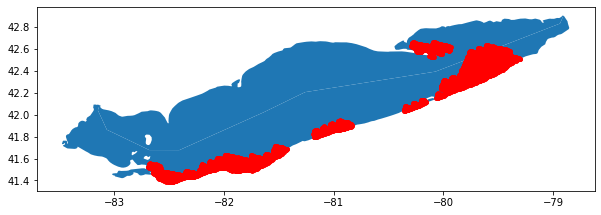

In [51]:
df_true = pd.DataFrame({'lat': lats_binary, 'lon': lons_binary, 'val': ice_cons_binary})
df_true['val'] = df_true['val'].round(decimals=2)
geometry = [Point(xy) for xy in zip(df_true['lon'], df_true['lat'])]
gdf_true = GeoDataFrame(df_true, geometry=geometry)  
lakes = gpd.read_file('/home/dsola/repos/PGA-Net/data/shapefiles/hydro_p_LakeErie.shp')
gdf_true[gdf_true['val']==0].plot(ax=lakes.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

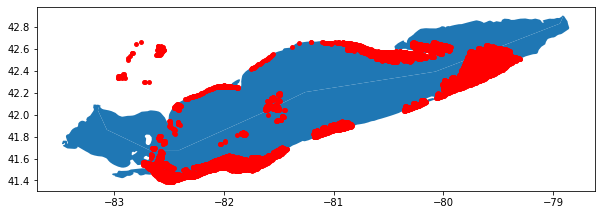

In [52]:
df_pred = pd.DataFrame({'lat': lats_binary, 'lon': lons_binary, 'val': preds})
df_pred['val'] = df_pred['val'].round(decimals=2)
geometry = [Point(xy) for xy in zip(df_pred['lon'], df_pred['lat'])]
gdf_pred = GeoDataFrame(df_pred, geometry=geometry)  
gdf_pred[gdf_pred['val']==0].plot(ax=lakes.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

### Plot Ones

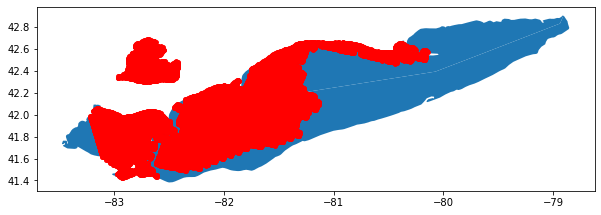

In [53]:
df_true = pd.DataFrame({'lat': lats_binary, 'lon': lons_binary, 'val': ice_cons_binary})
df_true['val'] = df_true['val'].round(decimals=2)
geometry = [Point(xy) for xy in zip(df_true['lon'], df_true['lat'])]
gdf_true = GeoDataFrame(df_true, geometry=geometry)  
gdf_true[gdf_true['val']==1].plot(ax=lakes.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

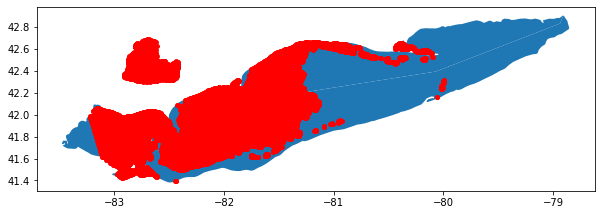

In [54]:
df_pred = pd.DataFrame({'lat': lats_binary, 'lon': lons_binary, 'val': preds})
df_pred['val'] = df_pred['val'].round(decimals=2)
geometry = [Point(xy) for xy in zip(df_pred['lon'], df_pred['lat'])]
gdf_pred = GeoDataFrame(df_pred, geometry=geometry)  
gdf_pred[gdf_pred['val']==1].plot(ax=lakes.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);